In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from qiskit.quantum_info import random_state
import numpy as np
import random
import matplotlib
import math
import random
from functions import *
import tensorflow as tf
import os
# import objgraph
import sys
import csv
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class Environment:

    def reset(self):
        state = random_state(2)
        new_state = state_norm(state)
        new_state = np.reshape(new_state.flatten(), (1,1,2))
        return new_state

In [3]:
# class epsilod_strategy():
#     def __init__(self, start, end, decay):
#         self.start = start
#         self.end = end
#         self.decay = decay
    
def get_exploration_rate(current_step, start, end, decay):

    return max(end, end + (start - end)/math.exp(1.*current_step*decay))

In [88]:
class Agent:
    def __init__(self, state_size, new_state, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 6 # measurement, CNOT, bit-flip
#         self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.value = new_state
        self.is_eval = is_eval
        self.done = False
#         self.final_state = [1/math.sqrt(2),1/math.sqrt(2)]

        self.gamma = 0.95
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.009
        self.learning_rate = 0.01
        self.model = self.QC_model()
        self.current_step = 0
        self.final_state = np.array([(1/math.sqrt(2))+0j,(1/math.sqrt(2))+0j])

#         self.model = load_model("models/" + model_name) if is_eval else self._model()

    def QC_model(self):
        model = Sequential()
        model.add(Dense(units=16, input_shape=self.state_size, activation="relu", name='layer1'))
        model.add(Dense(units=32, activation="relu", name='layer2'))
        model.add(Dense(units=8, activation="relu", name='layer3'))
        model.add(Dense(self.action_size, activation="softmax"))
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.003))
        return model


    def act(self, state, episode): #add episode to reduce the epsilon value
#        action = 0
        rate = get_exploration_rate(episode, self.epsilon_start, self.epsilon_end, self.epsilon_decay)
        if random.random() <= rate:
            options = self.model.predict(state)
            options = np.squeeze(options)
            action =  random.randrange(self.action_size)
        else:
            options = self.model.predict(state)
            options = np.squeeze(options)
#             print("PROBABILITIES: ", options)
            print(options)
            action = np.where(options == np.amax(options))[0][0]
        print("PROBABILITIES OPTIONS: ", options.shape)
#         options = np.squeeze(options)
        return action, options

    def train(self):
#         column_name = ['episode','time_step','reward', 'projection']
#         with open('reward.csv','a') as fd:
#             write_outfile = csv.writer(fd)
#             write_outfile.writerow(column_name)
        batch_size = 10
        t = 0                   #increment
        states, prob_actions, dlogps, drs, proj_data, reward_data =[], [], [], [], [], []
        tr_x, tr_y = [],[]
        avg_reward = []
        reward_sum = 0
        ep_number = 0
        prev_state = None
        new_state = self.value

        while ep_number<250:
            print("episode number: ",ep_number)
            prev_state = new_state
            states.append(new_state)
            action, probs = self.act(new_state, ep_number)
#             print("PROBABILITIES: ", probs.shape)
#             print("Action number: ", action)
#             print("Action: ", command[action])
#             print("Old State: ", new_state)
            prob_actions.append(probs)
            y = np.zeros([self.action_size])
            new_state = np.squeeze(new_state)
            y[action] = 1
            new_state = eval(command[action])
            if(np.allclose(new_state,self.final_state)):
                rw = 1
                drs.append(rw)
                reward_sum+=rw
                self.done = True
            if(t<4 and not np.allclose(new_state,self.final_state)):
                rw = reward(new_state, self.final_state)
                drs.append(rw)
                reward_sum+=rw
            elif(t==4):
                self.done = True
                if not np.allclose(new_state, self.final_state):
                    rw = -1
                    drs.append(rw)
                    reward_sum+=rw
#             reward_data = [ep_number, t, reward_sum, proj]
#             with open('reward.csv','a') as fd:
#                 write_outfile = csv.writer(fd)
#                 write_outfile.writerow(reward_data)
#            with open('reward.csv','a') as fd:
#                write_outfile = csv.writer(fd)
#                write_outfile.writerow((reward_sum))
            new_state = np.reshape(new_state, (1,1,2))
#             print("State: ", new_state)
            proj = projection(new_state, self.final_state)
#             print("projection: ", proj)
            proj_data.append(proj)
            print("reward till now: ",reward_sum)
#            print("probs: ", probs.shape)
            dlogps.append(np.array(y).astype('float32') * probs)
#             print("dlogps before time step: ",(dlogps[0].shape))
            del(probs, action)
            print("time step: ",t)
            t+=1
            if(self.done):                         #### Done State
                ep_number+=1
                ep_x = np.vstack(states)
#                 print("length of states: ", len(ep_x))
                ep_dlogp = np.vstack(dlogps)
#                 print("dlogps: ", len(dlogps))
                ep_reward = np.vstack(drs)
                disc_rw = discounted_reward(ep_reward,self.gamma)
#                 print("disc_rw: ", len(disc_rw))
#                 print("ep_dlogp: ", (ep_dlogp[0].shape))
                disc_rw = disc_rw.astype('float32')
                disc_rw -= np.mean(disc_rw)
                disc_rw /= np.std(disc_rw)

                tr_y_len = len(ep_dlogp)
#                 print("ep_dlogp: ", len(ep_dlogp))
                ep_dlogp*=disc_rw
#                states, drs =[], []
                if ep_number % batch_size == 0:

                    input_tr_y = prob_actions - self.learning_rate * ep_dlogp
#                    input_tr_y = ep_dlogp
                    input_tr_y = np.reshape(input_tr_y, (tr_y_len,1,6))

                    self.model.train_on_batch(ep_x, input_tr_y)
                    dlogps, drs, states, prob_actions,proj_data, reward_data = [],[],[],[],[],[]
                avg_reward.append((reward_sum)/ep_number)
                if(ep_number%1000==0):
                    self.model.save("model_ep{:}.h5".format(ep_number))
#                 if len(avg_reward)>100: avg_reward.pop(0)
                print('Episode {:} reward {:.2f}, Last 30ep Avg. rewards {:.2f}.'.format(
                    ep_number,reward_sum,avg_reward[ep_number-1]))
                env = Environment()
                state = env.reset()
                t=0
                self.done=False
#                 objgraph.show_most_common_types()

        return avg_reward

In [89]:
command = ['bit_flip_X(new_state)',
           'bit_flip_Y(new_state)',
           'hadamard_X(new_state)',
           'hadamard_Y(new_state)',
           'measurement(new_state[0],new_state[1])',
           'nothing(new_state)']

In [90]:
# def get_exploration_rate(current_step, start, end, decay):
        
#         return end + (start - end)/math.exp(1.*current_step*decay)

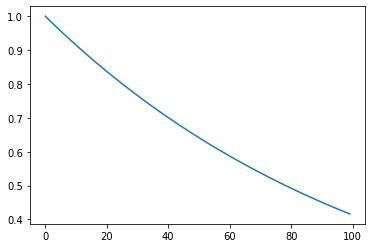

In [91]:
start = 1.0
end = 0.01
decay = 0.009
x = []
for i in range(100):
    x.append(max(end, get_exploration_rate(i, start, end, decay)))

plt.plot(x)
plt.show()

In [92]:
env = Environment()
state = env.reset()

agent = Agent(state[0].shape, state)
final_reward = agent.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  after removing the cwd from sys.path.


episode number:  0
PROBABILITIES OPTIONS:  (6,)
reward till now:  0
time step:  0
episode number:  0
PROBABILITIES OPTIONS:  (6,)
reward till now:  0
time step:  1
episode number:  0
PROBABILITIES OPTIONS:  (6,)
reward till now:  0
time step:  2
episode number:  0
PROBABILITIES OPTIONS:  (6,)
reward till now:  0
time step:  3
episode number:  0
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -1
time step:  4
Episode 1 reward -1.00, Last 30ep Avg. rewards -1.00.
episode number:  1
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[ 0.70710678+0.j         -0.        -0.70710678j]
 [ 0.        +0.70710678j -0.70710678+0.j        ]]
reward till now:  -1
time step:  0
episode number:  1
PROBABILITIES OPTIONS:  (6,)
reward till now:  -1
time step:  1
episode number:  1
PROBABILITIES OPTIONS:  (6,)
reward till now:  -1
time step:  2
episode number:  1
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
reward till now: 

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  after removing the cwd from sys.path.


Episode 10 reward -4.00, Last 30ep Avg. rewards -0.40.
episode number:  10
PROBABILITIES OPTIONS:  (6,)
reward till now:  -4
time step:  0
episode number:  10
[0.16678964 0.16693816 0.16648707 0.16612999 0.16671214 0.16694303]
PROBABILITIES OPTIONS:  (6,)
reward till now:  -4
time step:  1
episode number:  10
PROBABILITIES OPTIONS:  (6,)
reward till now:  -3
time step:  2
Episode 11 reward -3.00, Last 30ep Avg. rewards -0.27.
episode number:  11
PROBABILITIES OPTIONS:  (6,)
reward till now:  -3
time step:  0
episode number:  11
PROBABILITIES OPTIONS:  (6,)
[0.-0.70710678j 0.+0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -3
time step:  1
episode number:  11
PROBABILITIES OPTIONS:  (6,)
[0.+0.70710678j 0.-0.70710678j]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
reward till now:  -3
time step:  2
episode number:  11
PROBABILITIES OPTIONS:  (6,)
reward till now:  -3
time step:  3
episode number:  11
PROBABILITIES OPTIONS:  (6,)
reward till now:  -4
time step:  4
Episode 12 rewar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide


[0.16215436 0.17108425 0.17067158 0.16953689 0.16080177 0.16575111]
PROBABILITIES OPTIONS:  (6,)
reward till now:  -7
time step:  0
episode number:  31
PROBABILITIES OPTIONS:  (6,)
reward till now:  -6
time step:  1
Episode 32 reward -6.00, Last 30ep Avg. rewards -0.19.
episode number:  32
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j 0.70710678+0.j]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
reward till now:  -6
time step:  0
episode number:  32
PROBABILITIES OPTIONS:  (6,)
reward till now:  -6
time step:  1
episode number:  32
[0.16718861 0.16864623 0.16519788 0.16800609 0.16525857 0.16570261]
PROBABILITIES OPTIONS:  (6,)
reward till now:  -6
time step:  2
episode number:  32
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 0.+1.j]
[[0 1]
 [1 0]]
reward till now:  -6
time step:  3
episode number:  32
PROBABILITIES OPTIONS:  (6,)
[0.+1.j 0.+0.j]
[[ 0.70710678+0.j         -0.        -0.70710678j]
 [ 0.        +0.70710678j -0.70710678+0.j        ]]
reward till now:  -7
time step:  4
Epis

[0.1853163  0.16220672 0.15165736 0.15712994 0.1809568  0.16273293]
PROBABILITIES OPTIONS:  (6,)
[ 0.        -0.70710678j -0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -21
time step:  4
Episode 47 reward -21.00, Last 30ep Avg. rewards -0.45.
episode number:  47
PROBABILITIES OPTIONS:  (6,)
reward till now:  -21
time step:  0
episode number:  47
PROBABILITIES OPTIONS:  (6,)
reward till now:  -21
time step:  1
episode number:  47
PROBABILITIES OPTIONS:  (6,)
reward till now:  -21
time step:  2
episode number:  47
PROBABILITIES OPTIONS:  (6,)
[0.-1.j 0.+0.j]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
reward till now:  -21
time step:  3
episode number:  47
PROBABILITIES OPTIONS:  (6,)
[0.-0.70710678j 0.-0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -22
time step:  4
Episode 48 reward -22.00, Last 30ep Avg. rewards -0.46.
episode number:  48
PROBABILITIES OPTIONS:  (6,)
reward till now:  -22
time step:  0
episode number:  48
PROBABILITIES OPTIONS:  (6,)
reward till n

PROBABILITIES OPTIONS:  (6,)
reward till now:  -36
time step:  4
Episode 62 reward -36.00, Last 30ep Avg. rewards -0.58.
episode number:  62
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -36
time step:  0
episode number:  62
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -36
time step:  1
episode number:  62
[0.17515318 0.16541979 0.15774699 0.1638141  0.17111957 0.16674633]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -36
time step:  2
episode number:  62
[0.1682759  0.16943231 0.1717874  0.16485153 0.16056898 0.16508386]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
reward till now:  -36
time step:  3
episode number:  62
PROBABILITIES OPTIONS:  (6,)
reward till now:  -37
time step:  4
Episode 63 reward -37.00, Last 30ep Avg. rewards -0.59.
episode number:  63
PROBABILITIES OPTIONS:  (6,)
reward till now:  -37
time step:  0
episode numbe

PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
reward till now:  -50
time step:  0
Episode 78 reward -50.00, Last 30ep Avg. rewards -0.64.
episode number:  78
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j 0.70710678+0.j]
[[0 1]
 [1 0]]
reward till now:  -49
time step:  0
Episode 79 reward -49.00, Last 30ep Avg. rewards -0.62.
episode number:  79
[0.16898708 0.16883956 0.16454025 0.16564608 0.16530694 0.16668008]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j 0.70710678+0.j]
[[0 1]
 [1 0]]
reward till now:  -48
time step:  0
Episode 80 reward -48.00, Last 30ep Avg. rewards -0.60.
episode number:  80
[0.17182875 0.1678009  0.16167091 0.1644619  0.16757277 0.1666648 ]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j 0.70710678+0.j]
[[0 1]
 [1 0]]
reward till now:  -47
time step:  0
Episode 81 reward -47.00, Last 30ep Avg. rewards -0.58.
episode number:  81
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j 0.70710678+0.j]
[[ 0.70710678+0.j         -

[0.-1.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -49
time step:  3
episode number:  97
[0.1723161  0.16747452 0.16493618 0.16181321 0.16665325 0.16680677]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 0.-1.j]
[[0 1]
 [1 0]]
reward till now:  -50
time step:  4
Episode 98 reward -50.00, Last 30ep Avg. rewards -0.51.
episode number:  98
PROBABILITIES OPTIONS:  (6,)
[0.-1.j 0.+0.j]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
reward till now:  -50
time step:  0
episode number:  98
[0.1723161  0.16747452 0.16493618 0.16181321 0.16665325 0.16680677]
PROBABILITIES OPTIONS:  (6,)
[0.-0.70710678j 0.-0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -50
time step:  1
episode number:  98
[0.1723161  0.16747452 0.16493618 0.16181321 0.16665325 0.16680677]
PROBABILITIES OPTIONS:  (6,)
[0.-0.70710678j 0.-0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -50
time step:  2
episode number:  98
[0.1723161  0.16747452 0.16493618 0.16181321 0.16665325 0.16680677]
PROBABILITIES OPTIONS:  (6,)
[0.-0.70710678j 0.-0

time step:  0
episode number:  112
[0.19119073 0.15969305 0.1465592  0.15679514 0.18096736 0.16479456]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -62
time step:  1
episode number:  112
[0.17867649 0.16599967 0.16079657 0.16074808 0.1690184  0.16476084]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -62
time step:  2
episode number:  112
[0.19119073 0.15969305 0.1465592  0.15679514 0.18096736 0.16479456]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -62
time step:  3
episode number:  112
[0.17867649 0.16599967 0.16079657 0.16074808 0.1690184  0.16476084]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -63
time step:  4
Episode 113 reward -63.00, Last 30ep Avg. rewards -0.56.
episode number:  113
PROBABILITIES OPTIONS:  (6,)
reward till now:  -63
time step:  0
episode number:  113
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[ 0.70710678  0.70710678]
 [ 0.70710

[0.19604486 0.15828796 0.14316133 0.15486774 0.18368916 0.16394903]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -68
time step:  1
episode number:  130
[0.18197247 0.16510521 0.15755197 0.15939301 0.17150493 0.16447242]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -68
time step:  2
episode number:  130
[0.19604486 0.15828796 0.14316133 0.15486774 0.18368916 0.16394903]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -68
time step:  3
episode number:  130
[0.18197247 0.16510521 0.15755197 0.15939301 0.17150493 0.16447242]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -69
time step:  4
Episode 131 reward -69.00, Last 30ep Avg. rewards -0.53.
episode number:  131
[0.19604486 0.15828796 0.14316133 0.15486774 0.18368916 0.16394903]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -69
time step:  0
episode number:  131
[0.18197247 0.1651

[0.18323635 0.16449699 0.15640055 0.15812765 0.17289545 0.164843  ]
PROBABILITIES OPTIONS:  (6,)
[0.        +0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -80
time step:  0
episode number:  144
[0.1923333  0.16028567 0.14679298 0.15563068 0.18061069 0.16434675]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        +0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -80
time step:  1
episode number:  144
[0.18323635 0.16449699 0.15640055 0.15812765 0.17289545 0.164843  ]
PROBABILITIES OPTIONS:  (6,)
[0.        +0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -80
time step:  2
episode number:  144
PROBABILITIES OPTIONS:  (6,)
reward till now:  -80
time step:  3
episode number:  144
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -81
time step:  4
Episode 145 reward -81.00, Last 30ep Avg. rewards -0.56.
episode number:  145
[0.18363045 0.16473825 0.1563672  0.15865564 0.17233762 0.16427082]
PROBABILITIES OPTIONS

Episode 159 reward -93.00, Last 30ep Avg. rewards -0.58.
episode number:  159
[0.1945645  0.15968645 0.14558566 0.15488403 0.18144871 0.16383065]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        +0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -93
time step:  0
episode number:  159
[0.18519887 0.16393095 0.15520059 0.15740567 0.17378359 0.16448031]
PROBABILITIES OPTIONS:  (6,)
[0.        +0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -93
time step:  1
episode number:  159
PROBABILITIES OPTIONS:  (6,)
reward till now:  -93
time step:  2
episode number:  159
PROBABILITIES OPTIONS:  (6,)
reward till now:  -93
time step:  3
episode number:  159
[0.1945645  0.15968645 0.14558566 0.15488403 0.18144871 0.16383065]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        +0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -94
time step:  4
Episode 160 reward -94.00, Last 30ep Avg. rewards -0.59.
episode number:  160
[0.18684493 0.16348979 0.15410578 0.156932

[0.19847985 0.15856928 0.1429392  0.15391605 0.1833253  0.16277036]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        -0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -104
time step:  3
episode number:  172
[0.18824242 0.16307849 0.15297373 0.15660843 0.17536715 0.16372977]
PROBABILITIES OPTIONS:  (6,)
[0.        -0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  4
Episode 173 reward -105.00, Last 30ep Avg. rewards -0.61.
episode number:  173
[0.19847985 0.15856928 0.1429392  0.15391605 0.1833253  0.16277036]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        -0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  0
episode number:  173
PROBABILITIES OPTIONS:  (6,)
reward till now:  -105
time step:  1
episode number:  173
[0.20521966 0.15572275 0.13714717 0.15212776 0.18797038 0.16181229]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  2
episode number:  173
[0.18923426 0.1

[0.18372796 0.16510643 0.15602686 0.15790394 0.17290641 0.16432838]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 0.+1.j]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  4
Episode 193 reward -105.00, Last 30ep Avg. rewards -0.54.
episode number:  193
[0.18372796 0.16510643 0.15602686 0.15790394 0.17290641 0.16432838]
PROBABILITIES OPTIONS:  (6,)
[0.+1.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  0
episode number:  193
[0.18372796 0.16510643 0.15602686 0.15790394 0.17290641 0.16432838]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 0.+1.j]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  1
episode number:  193
[0.18372796 0.16510643 0.15602686 0.15790394 0.17290641 0.16432838]
PROBABILITIES OPTIONS:  (6,)
[0.+1.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  2
episode number:  193
[0.18372796 0.16510643 0.15602686 0.15790394 0.17290641 0.16432838]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 0.+1.j]
[[0 1]
 [1 0]]
reward till now:  -105
time step:  3
episode number:  193
PROBABILITIE

PROBABILITIES OPTIONS:  (6,)
[ 0.70710678+0.j -0.70710678+0.j]
[[0 1]
 [1 0]]
reward till now:  -118
time step:  2
episode number:  206
[0.1759502  0.16787274 0.14977683 0.16365416 0.17554756 0.16719857]
PROBABILITIES OPTIONS:  (6,)
[-0.70710678+0.j  0.70710678+0.j]
[[0 1]
 [1 0]]
reward till now:  -118
time step:  3
episode number:  206
[0.23144244 0.14846379 0.14716767 0.1382528  0.18184909 0.15282422]
PROBABILITIES OPTIONS:  (6,)
[ 0.70710678+0.j -0.70710678+0.j]
[[0 1]
 [1 0]]
reward till now:  -119
time step:  4
Episode 207 reward -119.00, Last 30ep Avg. rewards -0.57.
episode number:  207
[0.1759502  0.16787274 0.14977683 0.16365416 0.17554756 0.16719857]
PROBABILITIES OPTIONS:  (6,)
[-0.70710678+0.j  0.70710678+0.j]
[[0 1]
 [1 0]]
reward till now:  -119
time step:  0
episode number:  207
PROBABILITIES OPTIONS:  (6,)
reward till now:  -119
time step:  1
episode number:  207
[0.23144244 0.14846379 0.14716767 0.1382528  0.18184909 0.15282422]
PROBABILITIES OPTIONS:  (6,)
[ 0.707106

reward till now:  -129
time step:  1
episode number:  217
[0.19258268 0.16255802 0.14804488 0.15686387 0.17775065 0.16219988]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -129
time step:  2
episode number:  217
[0.21172068 0.15401988 0.13144822 0.1509394  0.19185174 0.1600201 ]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -129
time step:  3
episode number:  217
[0.19258268 0.16255802 0.14804488 0.15686387 0.17775065 0.16219988]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till now:  -130
time step:  4
Episode 218 reward -130.00, Last 30ep Avg. rewards -0.60.
episode number:  218
[0.21172068 0.15401988 0.13144822 0.1509394  0.19185174 0.1600201 ]
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[0 1]
 [1 0]]
reward till now:  -130
time step:  0
episode number:  218
[0.19258268 0.16255802 0.14804488 0.15686387 0.17775065 0.16219988]
PROBABILITIES OPTIONS:  (6,)
[0.+0.j 1.+0.j]
[[0 1]
 [1 0]]
reward till 

time step:  0
episode number:  236
PROBABILITIES OPTIONS:  (6,)
[1.+0.j 0.+0.j]
[[ 0.70710678+0.j         -0.        -0.70710678j]
 [ 0.        +0.70710678j -0.70710678+0.j        ]]
reward till now:  -128
time step:  1
episode number:  236
[0.20528387 0.15695971 0.13540399 0.15292682 0.18859546 0.16083013]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        +0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -128
time step:  2
episode number:  236
[0.1899774  0.16345681 0.14749296 0.15765826 0.1783981  0.16301653]
PROBABILITIES OPTIONS:  (6,)
[0.        +0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -128
time step:  3
episode number:  236
[0.20528387 0.15695971 0.13540399 0.15292682 0.18859546 0.16083013]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        +0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -129
time step:  4
Episode 237 reward -129.00, Last 30ep Avg. rewards -0.54.
episode number:  237
PROBABILITIES OPTIONS:  (6,)
[0.        +0.7071

[0.        +0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -138
time step:  4
Episode 246 reward -138.00, Last 30ep Avg. rewards -0.56.
episode number:  246
[0.20550656 0.15691456 0.13424975 0.15302461 0.1896092  0.16069528]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        +0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -138
time step:  0
episode number:  246
[0.18889667 0.16401637 0.1470298  0.15836841 0.17858097 0.16310777]
PROBABILITIES OPTIONS:  (6,)
[0.        +0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward till now:  -138
time step:  1
episode number:  246
[0.20550656 0.15691456 0.13424975 0.15302461 0.1896092  0.16069528]
PROBABILITIES OPTIONS:  (6,)
[0.70710678+0.j         0.        +0.70710678j]
[[0 1]
 [1 0]]
reward till now:  -138
time step:  2
episode number:  246
[0.18889667 0.16401637 0.1470298  0.15836841 0.17858097 0.16310777]
PROBABILITIES OPTIONS:  (6,)
[0.        +0.70710678j 0.70710678+0.j        ]
[[0 1]
 [1 0]]
reward 

In [93]:
# final_reward

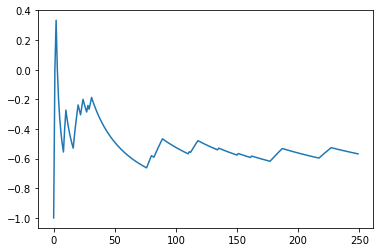

In [94]:
plt.plot(final_reward)
plt.show()